<a href="https://colab.research.google.com/github/donghyuun/2022_1_WAP_WEB_TEAM5_MAIN/blob/main/data_agumentation_sawtooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   conductivity  feed_pressure
0        0.2500       0.000000
1        0.2500       0.076875
2        0.2500       0.114375
3        0.3125       0.496875
4        0.3125       3.421875


<ipython-input-12-709a1efffd29>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(outlier_idx, axis=0, inplace=True)


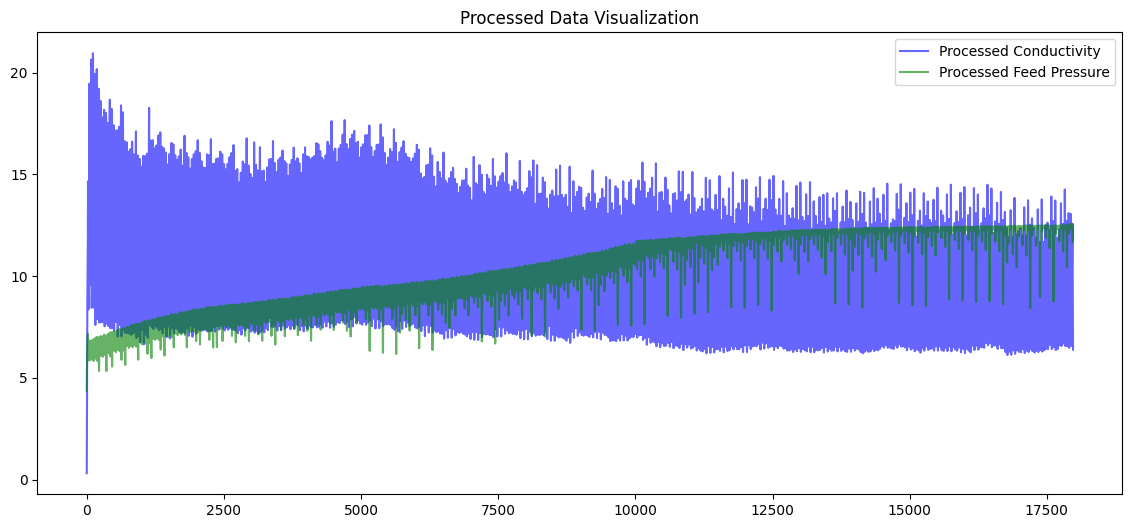

In [12]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

# CSV 파일 불러오기 및 처리
file_name = '통합운전데이터.rev01.csv'
df = pd.read_csv(file_name)

# E열 (처리수 전기전도도), K열 (RO유입압력) 추출
df_selected = df[['RO 처리수 전기전도도(uS/cm)', 'RO유입 압력(bar)']]
df_selected.columns = ['conductivity', 'feed_pressure']

# 데이터 확인
print(df_selected.head())

# 원본 데이터 저장 (전혀 처리하지 않은 데이터)
original_conductivity = df_selected['conductivity'].values
original_feed_pressure = df_selected['feed_pressure'].values

################## 전처리 시작 #########################

# 아웃라이어 제거 함수 (IQR 방식 적용)
def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest = quantile_25 - IQR_weight * 1.423 / 1.5
    highest = quantile_75 + IQR_weight * 1.6 / 1.5

    outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
    return outlier_idx

# 두 변수에 대한 이상치 제거(개별적으로 적용)
for column in ['conductivity', 'feed_pressure']:
    outlier_idx = get_outlier(df=df_selected, column=column, weight=1.5)
    df_selected.drop(outlier_idx, axis=0, inplace=True)

# 각 변수에 대해 별도의 Min-Max 스케일러 적용
scaler_conductivity = MinMaxScaler()
scaler_feed_pressure = MinMaxScaler()

scaled_conductivity = scaler_conductivity.fit_transform(df_selected['conductivity'].values.reshape(-1, 1))
scaled_feed_pressure = scaler_feed_pressure.fit_transform(df_selected['feed_pressure'].values.reshape(-1, 1))

# 데이터 스무딩 및 인터폴레이션 함수 정의
def smooth_and_interpolate(data, window_size):
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='same')

    def add_padding(data, padding_size):
        start_padding = np.full(padding_size, data[0])
        end_padding = np.full(padding_size, data[-1])
        return np.concatenate([start_padding, data, end_padding])

    # 패딩 적용
    padded_data = add_padding(data.flatten(), window_size)

    # 이동 평균 적용
    rolled_data = moving_average(padded_data, window_size)

    # 패딩 제거
    rolled_data_trimmed = rolled_data[window_size:-window_size]

    # 새로운 x축 포인트 생성 (인터폴레이션)
    x_new = np.linspace(0, len(rolled_data_trimmed) - 1, len(data) * 2)
    f_interpolated = interp1d(range(len(rolled_data_trimmed)), rolled_data_trimmed, kind='linear')
    interpolated_data = f_interpolated(x_new)

    return interpolated_data

# 이동 평균 윈도우 크기
window_size = 5

# 데이터 스무딩 및 인터폴레이션
smoothed_conductivity = smooth_and_interpolate(scaled_conductivity, window_size)
smoothed_feed_pressure = smooth_and_interpolate(scaled_feed_pressure, window_size)

# 스케일 역변환 (원래 데이터 범위로 복원)
smoothed_conductivity = scaler_conductivity.inverse_transform(smoothed_conductivity.reshape(-1, 1))
smoothed_feed_pressure = scaler_feed_pressure.inverse_transform(smoothed_feed_pressure.reshape(-1, 1))

# 전처리된 최종 데이터 저장
final_processed_df = pd.DataFrame({
    'Processed Conductivity': smoothed_conductivity.flatten(),
    'Processed Feed Pressure': smoothed_feed_pressure.flatten()
})

# 결과를 시각화
plt.figure(figsize=(14, 6))
plt.plot(final_processed_df['Processed Conductivity'], label='Processed Conductivity', color='blue', alpha=0.6)
plt.plot(final_processed_df['Processed Feed Pressure'], label='Processed Feed Pressure', color='green', alpha=0.6)
plt.title('Processed Data Visualization')
plt.legend()
plt.show()


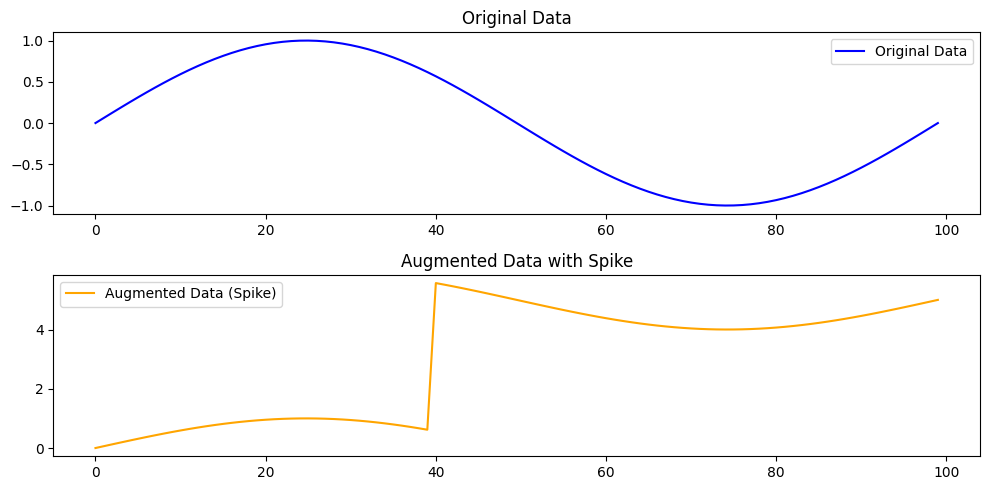

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 원본 데이터 생성 (평탄한 데이터)
original_data = np.sin(np.linspace(0, 2 * np.pi, 100))

# 특정 구간에 변화를 주는 함수
def augment_data_with_spike(data, spike_value=5, spike_position=50):
    augmented_data = data.copy()
    augmented_data[spike_position:] += spike_value  # 특정 위치 이후로 스파이크를 추가
    return augmented_data

# 데이터 증강 (변화 추가)
augmented_data = augment_data_with_spike(original_data, spike_value=5, spike_position=40)

# 데이터 시각화
plt.figure(figsize=(10, 5))

# 원본 데이터 시각화
plt.subplot(2, 1, 1)
plt.plot(original_data, label='Original Data', color='blue')
plt.title('Original Data')
plt.legend()

# 증강된 데이터 시각화
plt.subplot(2, 1, 2)
plt.plot(augmented_data, label='Augmented Data (Spike)', color='orange')
plt.title('Augmented Data with Spike')
plt.legend()

plt.tight_layout()
plt.show()


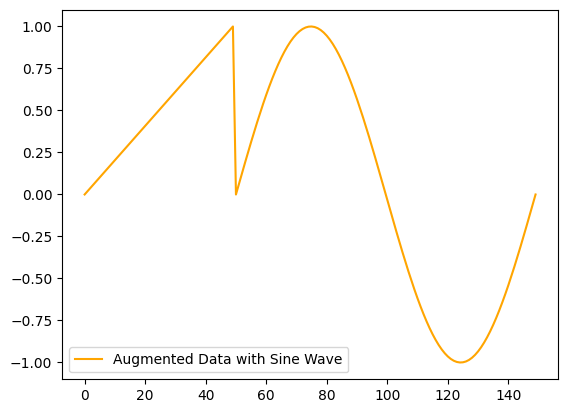

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 기존의 데이터 (빨간 부분: 선형 데이터)
linear_data = np.linspace(0, 1, 50)  # 예시: 50개의 선형 데이터

# 사인 함수를 이용해 증강할 데이터 생성 (한 주기)
num_points = 100
sin_data = np.sin(np.linspace(0, 2 * np.pi, num_points))

# 선형 데이터를 사인 데이터로 증강
augmented_data = np.concatenate([linear_data, sin_data])

# 증강된 데이터 시각화
plt.plot(augmented_data, label='Augmented Data with Sine Wave', color='orange')
plt.legend()
plt.show()


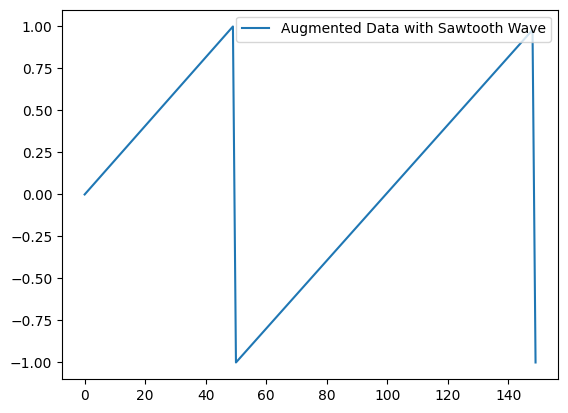

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 빨간 부분 선형 데이터 (현재 있는 데이터)
linear_data = np.linspace(0, 1, 50)  # 선형 부분

# 톱니파 형태의 데이터 생성
sawtooth_data = signal.sawtooth(np.linspace(0, 2 * np.pi, 100))  # 주기적인 톱니파 데이터

# 선형 데이터와 톱니파 데이터 합치기
augmented_data = np.concatenate([linear_data, sawtooth_data])

# 데이터 시각화
plt.plot(augmented_data, label='Augmented Data with Sawtooth Wave')
plt.legend()
plt.show()


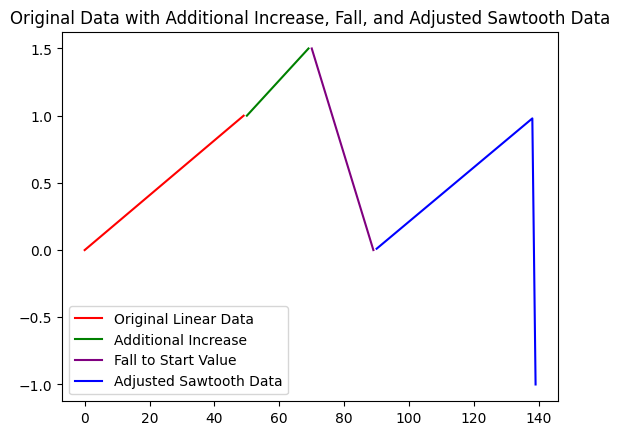

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 빨간 부분 선형 데이터 (현재 있는 데이터)
linear_data = np.linspace(0, 1, 50)  # 선형 부분

# 추가적인 증가 구간
additional_increase = np.linspace(1, 1.5, 20)  # 빨간 부분 이후 더 증가하는 구간

# 빨간 부분의 처음 값으로 떨어지는 구간
fall_to_start = np.linspace(1.5, linear_data[0], 20)  # 빨간 부분의 처음 값으로 하락

# 톱니파 형태로 다시 증가
sawtooth_data = signal.sawtooth(np.linspace(0, 2 * np.pi, 100))  # 주기적인 톱니파 데이터
sawtooth_data_adjusted = sawtooth_data[50:] + linear_data[0]  # 톱니파의 하락을 빨간 부분의 처음 값에서 시작

# 선형 데이터 + 추가 증가 구간 + 하락 구간 + 톱니파 상승 구간
augmented_data = np.concatenate([linear_data, additional_increase, fall_to_start, sawtooth_data_adjusted])

# 데이터 시각화
plt.plot(linear_data, label='Original Linear Data', color='red')
plt.plot(np.arange(len(linear_data), len(linear_data) + len(additional_increase)), additional_increase, label='Additional Increase', color='green')
plt.plot(np.arange(len(linear_data) + len(additional_increase), len(linear_data) + len(additional_increase) + len(fall_to_start)), fall_to_start, label='Fall to Start Value', color='purple')
plt.plot(np.arange(len(linear_data) + len(additional_increase) + len(fall_to_start), len(augmented_data)), sawtooth_data_adjusted, label='Adjusted Sawtooth Data', color='blue')

plt.legend()
plt.title("Original Data with Additional Increase, Fall, and Adjusted Sawtooth Data")
plt.show()


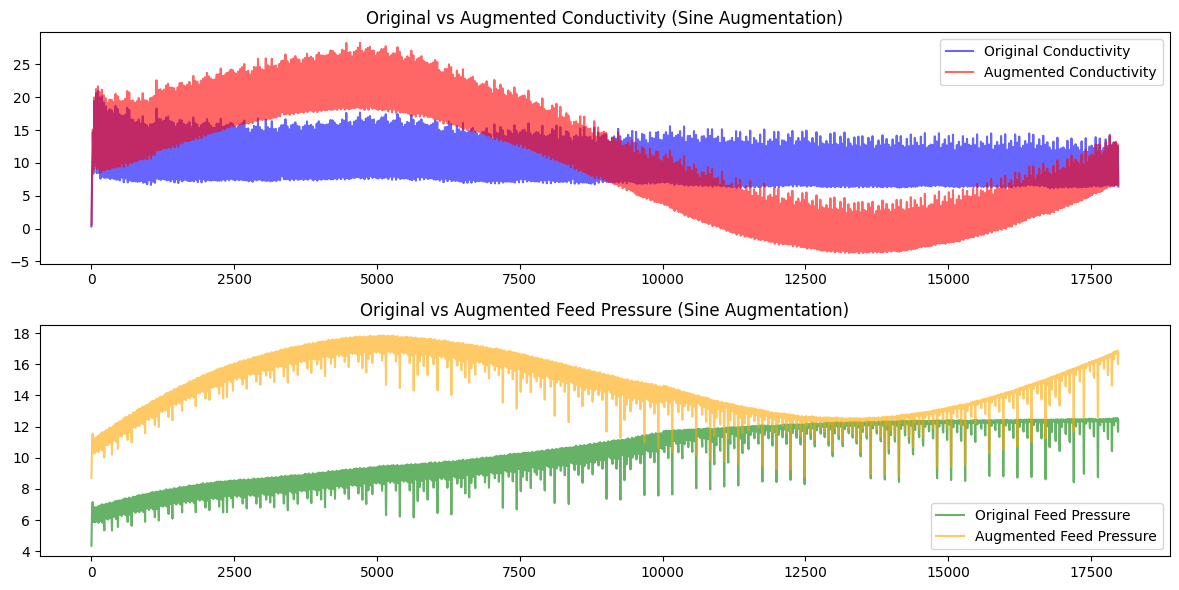

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 증강을 위한 사인 함수 기반 데이터 생성
def apply_sine_augmentation(data, amplitude=1, frequency=1, phase=0, shift=0):
    """
    사인 함수 기반으로 데이터를 증강하는 함수
    amplitude: 진폭 (데이터의 최대값을 설정)
    frequency: 주파수 (반복 주기 설정)
    phase: 위상 (사이클의 시작 지점 조정)
    shift: 데이터 이동을 위한 상수
    """
    x = np.linspace(0, 2 * np.pi, len(data))
    sine_wave = amplitude * np.sin(frequency * x + phase) + shift
    augmented_data = data + sine_wave
    return augmented_data

# 최대값을 찾아서 그 값을 기준으로 증강
max_conductivity = np.max(original_conductivity)
min_conductivity = np.min(original_conductivity)

# 사인 함수 적용 (주기적으로 최고점까지 도달 후 다시 0으로 내려감)
augmented_conductivity = apply_sine_augmentation(original_conductivity, amplitude=(max_conductivity - min_conductivity) / 2, frequency=1, shift=min_conductivity)
augmented_feed_pressure = apply_sine_augmentation(original_feed_pressure, amplitude=(np.max(original_feed_pressure) - np.min(original_feed_pressure)) / 2, frequency=1, shift=np.min(original_feed_pressure))

# 증강된 데이터 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(original_conductivity, label='Original Conductivity', color='blue', alpha=0.6)
plt.plot(augmented_conductivity, label='Augmented Conductivity', color='red', alpha=0.6)
plt.title('Original vs Augmented Conductivity (Sine Augmentation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(original_feed_pressure, label='Original Feed Pressure', color='green', alpha=0.6)
plt.plot(augmented_feed_pressure, label='Augmented Feed Pressure', color='orange', alpha=0.6)
plt.title('Original vs Augmented Feed Pressure (Sine Augmentation)')
plt.legend()

plt.tight_layout()
plt.show()


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

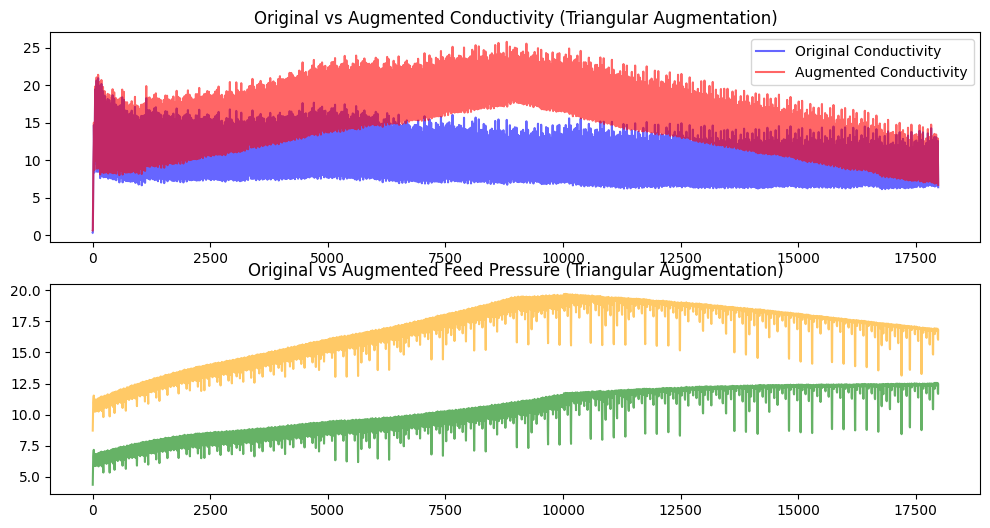

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 증강을 위한 삼각 함수 기반 데이터 생성
def apply_triangular_augmentation(data, amplitude=1, period=1, shift=0):
    """
    삼각 함수 기반으로 데이터를 증강하는 함수
    amplitude: 진폭 (데이터의 최대값을 설정)
    period: 주기 (반복 주기 설정)
    shift: 데이터 이동을 위한 상수
    """
    x = np.linspace(0, 1, len(data))

    # 삼각 함수 생성: 삼각 파형을 만들어서 값이 천천히 증가하다가 급격히 하락
    triangular_wave = 2 * amplitude * np.abs(x - np.floor(x + 0.5)) + shift
    augmented_data = data + triangular_wave * period

    return augmented_data

# 최대값을 찾아서 그 값을 기준으로 증강
max_conductivity = np.max(original_conductivity)
min_conductivity = np.min(original_conductivity)

# 삼각 함수 적용 (급격히 하락하는 패턴 적용)
augmented_conductivity = apply_triangular_augmentation(original_conductivity, amplitude=(max_conductivity - min_conductivity) / 2, period=1, shift=min_conductivity)
augmented_feed_pressure = apply_triangular_augmentation(original_feed_pressure, amplitude=(np.max(original_feed_pressure) - np.min(original_feed_pressure)) / 2, period=1, shift=np.min(original_feed_pressure))

# 증강된 데이터 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(original_conductivity, label='Original Conductivity', color='blue', alpha=0.6)
plt.plot(augmented_conductivity, label='Augmented Conductivity', color='red', alpha=0.6)
plt.title('Original vs Augmented Conductivity (Triangular Augmentation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(original_feed_pressure, label='Original Feed Pressure', color='green', alpha=0.6)
plt.plot(augmented_feed_pressure, label='Augmented Feed Pressure', color='orange', alpha=0.6)
plt.title('Original vs Augmented Feed Pressure (Triangular Augmentation)')
plt


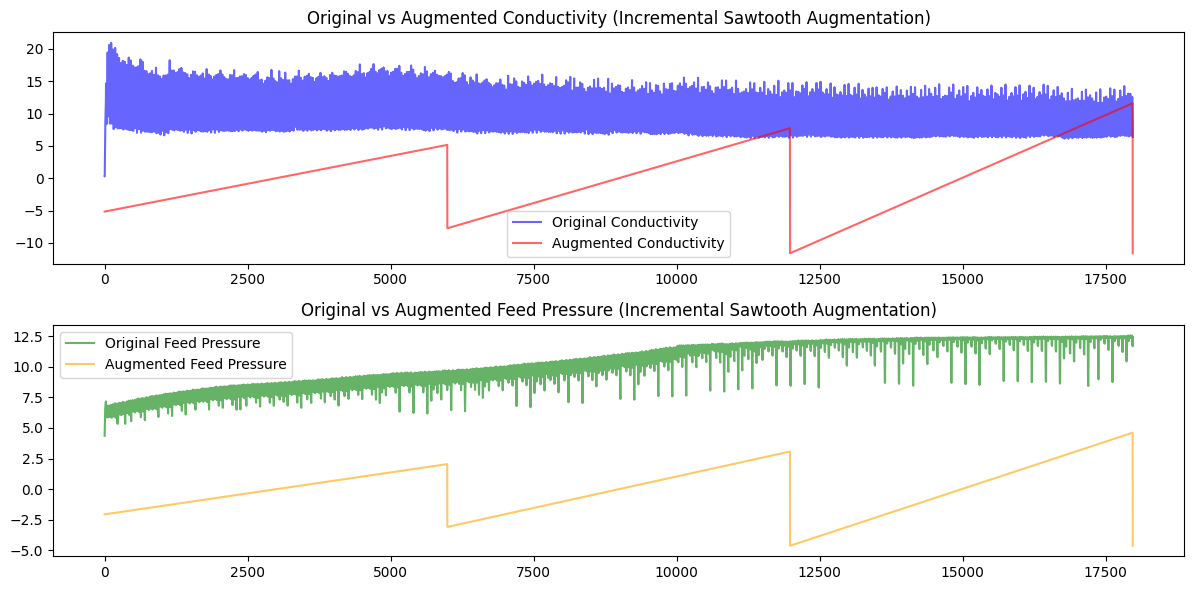

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal  # 톱니 함수 생성에 사용

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 증가하는 톱니 함수 기반 증강 함수
def apply_incremental_sawtooth_augmentation(data, initial_amplitude=1, period=1, cycles=5):
    """
    증가하는 톱니 함수 기반 데이터 증강
    initial_amplitude: 첫 주기의 톱니 함수의 진폭 (첫 최고점)
    period: 주기 (얼마나 자주 최고점에서 하락할지 설정)
    cycles: 톱니 패턴의 반복 횟수 (몇 번의 톱니 패턴을 반복할지)
    """
    augmented_data = []
    current_amplitude = initial_amplitude

    for cycle in range(cycles):
        # 톱니 함수 생성: 각 주기마다 진폭이 증가함
        x = np.linspace(0, 1, len(data) // cycles)
        sawtooth_wave = current_amplitude * signal.sawtooth(2 * np.pi * period * x)

        # 데이터에 증강된 톱니 파형을 추가
        augmented_data.extend(sawtooth_wave)

        # 진폭을 증가시켜서 다음 사이클에서 더 높은 값까지 도달
        current_amplitude *= 1.5  # 주기마다 1.5배씩 진폭 증가

    return np.array(augmented_data[:len(data)])  # 원래 데이터 길이만큼 자르기

# 최대값을 찾아서 그 값을 기준으로 증강
max_conductivity = np.max(original_conductivity)
min_conductivity = np.min(original_conductivity)

# 톱니 함수 적용 (점진적 증가와 급격한 하락 패턴 적용)
augmented_conductivity = apply_incremental_sawtooth_augmentation(
    original_conductivity, initial_amplitude=(max_conductivity - min_conductivity) / 4, period=1, cycles=3)
augmented_feed_pressure = apply_incremental_sawtooth_augmentation(
    original_feed_pressure, initial_amplitude=(np.max(original_feed_pressure) - np.min(original_feed_pressure)) / 4, period=1, cycles=3)

# 증강된 데이터 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(original_conductivity, label='Original Conductivity', color='blue', alpha=0.6)
plt.plot(augmented_conductivity, label='Augmented Conductivity', color='red', alpha=0.6)
plt.title('Original vs Augmented Conductivity (Incremental Sawtooth Augmentation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(original_feed_pressure, label='Original Feed Pressure', color='green', alpha=0.6)
plt.plot(augmented_feed_pressure, label='Augmented Feed Pressure', color='orange', alpha=0.6)
plt.title('Original vs Augmented Feed Pressure (Incremental Sawtooth Augmentation)')
plt.legend()

plt.tight_layout()
plt.show()


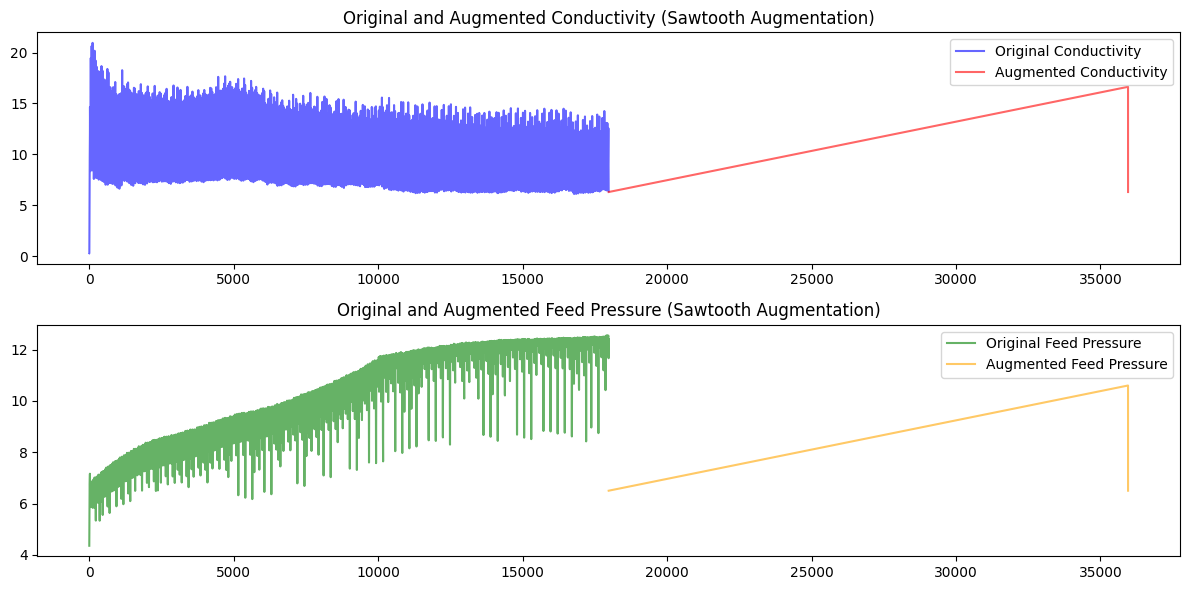

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal  # 톱니 함수 생성에 사용

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 증가하는 톱니 함수 기반 증강 함수
def apply_incremental_sawtooth_augmentation(data, initial_amplitude=1, period=1, cycles=3):
    """
    증가하는 톱니 함수 기반 데이터 증강
    initial_amplitude: 첫 주기의 톱니 함수의 진폭 (첫 최고점)
    period: 톱니 함수의 주기 (얼마나 자주 최고점에서 하락할지 설정)
    cycles: 톱니 패턴의 반복 횟수
    """
    augmented_data = []
    current_amplitude = initial_amplitude
    start_value = data[9]  # 시작점을 기존 데이터의 10번째 값으로 설정

    for cycle in range(cycles):
        # 톱니 함수 생성: 각 주기마다 진폭이 증가함
        x = np.linspace(0, 1, len(data))
        sawtooth_wave = current_amplitude * signal.sawtooth(2 * np.pi * period * x)

        # 톱니 파형의 시작점을 기존 데이터의 10번째 값에 맞춤
        sawtooth_wave += start_value - sawtooth_wave[0]

        # 데이터에 증강된 톱니 파형을 추가
        augmented_data.extend(sawtooth_wave)

        # 진폭을 증가시켜서 다음 사이클에서 더 높은 값까지 도달
        current_amplitude *= 1.5  # 주기마다 1.5배씩 진폭 증가

    return np.array(augmented_data[:len(data)])  # 원래 데이터 길이만큼 자르기

# 최대값을 찾아서 그 값을 기준으로 증강
max_conductivity = np.max(original_conductivity)
min_conductivity = np.min(original_conductivity)

# 톱니 함수 적용 (점진적 증가와 급격한 하락 패턴 적용)
augmented_conductivity = apply_incremental_sawtooth_augmentation(
    original_conductivity, initial_amplitude=(max_conductivity - min_conductivity) / 4, period=1, cycles=3)
augmented_feed_pressure = apply_incremental_sawtooth_augmentation(
    original_feed_pressure, initial_amplitude=(np.max(original_feed_pressure) - np.min(original_feed_pressure)) / 4, period=1, cycles=3)

# 기존 데이터에 증강된 데이터 추가
combined_conductivity = np.concatenate([original_conductivity, augmented_conductivity])
combined_feed_pressure = np.concatenate([original_feed_pressure, augmented_feed_pressure])

# 증강된 데이터와 원본 데이터를 구분하여 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(original_conductivity)), original_conductivity, label='Original Conductivity', color='blue', alpha=0.6)
plt.plot(np.arange(len(original_conductivity), len(combined_conductivity)), augmented_conductivity, label='Augmented Conductivity', color='red', alpha=0.6)
plt.title('Original and Augmented Conductivity (Sawtooth Augmentation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(original_feed_pressure)), original_feed_pressure, label='Original Feed Pressure', color='green', alpha=0.6)
plt.plot(np.arange(len(original_feed_pressure), len(combined_feed_pressure)), augmented_feed_pressure, label='Augmented Feed Pressure', color='orange', alpha=0.6)
plt.title('Original and Augmented Feed Pressure (Sawtooth Augmentation)')
plt.legend()

plt.tight_layout()
plt.show()


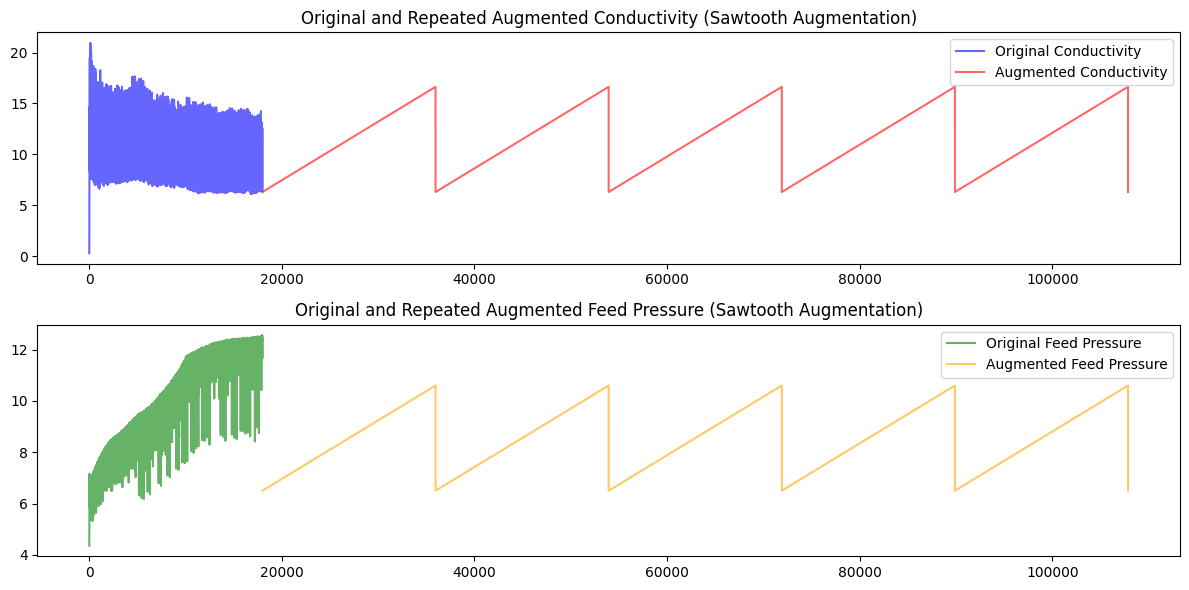

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal  # 톱니 함수 생성에 사용

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 반복되는 톱니 함수 기반 증강 함수
def apply_repeating_sawtooth_augmentation(data, amplitude=1, period=1, cycles=3, repetitions=5):
    """
    반복되는 톱니 함수 기반 데이터 증강
    amplitude: 톱니 함수의 진폭 (최고점)
    period: 톱니 함수의 주기 (얼마나 자주 최고점에서 하락할지 설정)
    cycles: 톱니 패턴의 반복 횟수 (한 번의 반복에서 톱니가 몇 번 나타날지)
    repetitions: 전체적으로 톱니 패턴을 몇 번 반복할지 설정
    """
    augmented_data = []
    start_value = data[9]  # 시작점을 기존 데이터의 10번째 값으로 설정

    for rep in range(repetitions):
        for cycle in range(cycles):
            # 톱니 함수 생성: 진폭은 일정하게 유지함
            x = np.linspace(0, 1, len(data))
            sawtooth_wave = amplitude * signal.sawtooth(2 * np.pi * period * x)

            # 톱니 파형의 시작점을 기존 데이터의 10번째 값에 맞춤
            sawtooth_wave += start_value - sawtooth_wave[0]

            # 데이터에 증강된 톱니 파형을 추가
            augmented_data.extend(sawtooth_wave)

    return np.array(augmented_data[:len(data) * repetitions])  # 원하는 반복 횟수만큼 자르기

# 톱니 함수 적용 (반복되는 톱니 패턴 적용, 진폭 1배로 유지)
augmented_conductivity = apply_repeating_sawtooth_augmentation(
    original_conductivity, amplitude=(np.max(original_conductivity) - np.min(original_conductivity)) / 4, period=1, cycles=3, repetitions=5)
augmented_feed_pressure = apply_repeating_sawtooth_augmentation(
    original_feed_pressure, amplitude=(np.max(original_feed_pressure) - np.min(original_feed_pressure)) / 4, period=1, cycles=3, repetitions=5)

# 기존 데이터에 증강된 데이터 추가
combined_conductivity = np.concatenate([original_conductivity, augmented_conductivity])
combined_feed_pressure = np.concatenate([original_feed_pressure, augmented_feed_pressure])

# 증강된 데이터와 원본 데이터를 구분하여 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(original_conductivity)), original_conductivity, label='Original Conductivity', color='blue', alpha=0.6)
plt.plot(np.arange(len(original_conductivity), len(combined_conductivity)), augmented_conductivity, label='Augmented Conductivity', color='red', alpha=0.6)
plt.title('Original and Repeated Augmented Conductivity (Sawtooth Augmentation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(original_feed_pressure)), original_feed_pressure, label='Original Feed Pressure', color='green', alpha=0.6)
plt.plot(np.arange(len(original_feed_pressure), len(combined_feed_pressure)), augmented_feed_pressure, label='Augmented Feed Pressure', color='orange', alpha=0.6)
plt.title('Original and Repeated Augmented Feed Pressure (Sawtooth Augmentation)')
plt.legend()

plt.tight_layout()
plt.show()


# 새 섹션

amplitude:  5.1584634185347955
start_value:  6.318340101240474
sawtooth_wave:  [ 6.3183401   6.318914    6.31948789 ... 16.63411915 16.63469304
  6.3183401 ]  amplitude:  5.1584634185347955
sawtooth_wave:  [ 6.3183401   6.318914    6.31948789 ... 16.63411915 16.63469304
  6.3183401 ]  amplitude:  5.1584634185347955
sawtooth_wave:  [ 6.3183401   6.318914    6.31948789 ... 16.63411915 16.63469304
  6.3183401 ]  amplitude:  5.1584634185347955
sawtooth_wave:  [ 6.3183401   6.318914    6.31948789 ... 16.63411915 16.63469304
  6.3183401 ]  amplitude:  5.1584634185347955
sawtooth_wave:  [ 6.3183401   6.318914    6.31948789 ... 16.63411915 16.63469304
  6.3183401 ]  amplitude:  5.1584634185347955
sawtooth_wave:  [ 6.3183401   6.318914    6.31948789 ... 16.63411915 16.63469304
  6.3183401 ]  amplitude:  5.1584634185347955
sawtooth_wave:  [ 6.3183401   6.318914    6.31948789 ... 16.63411915 16.63469304
  6.3183401 ]  amplitude:  5.1584634185347955
sawtooth_wave:  [ 6.3183401   6.318914    6.3194

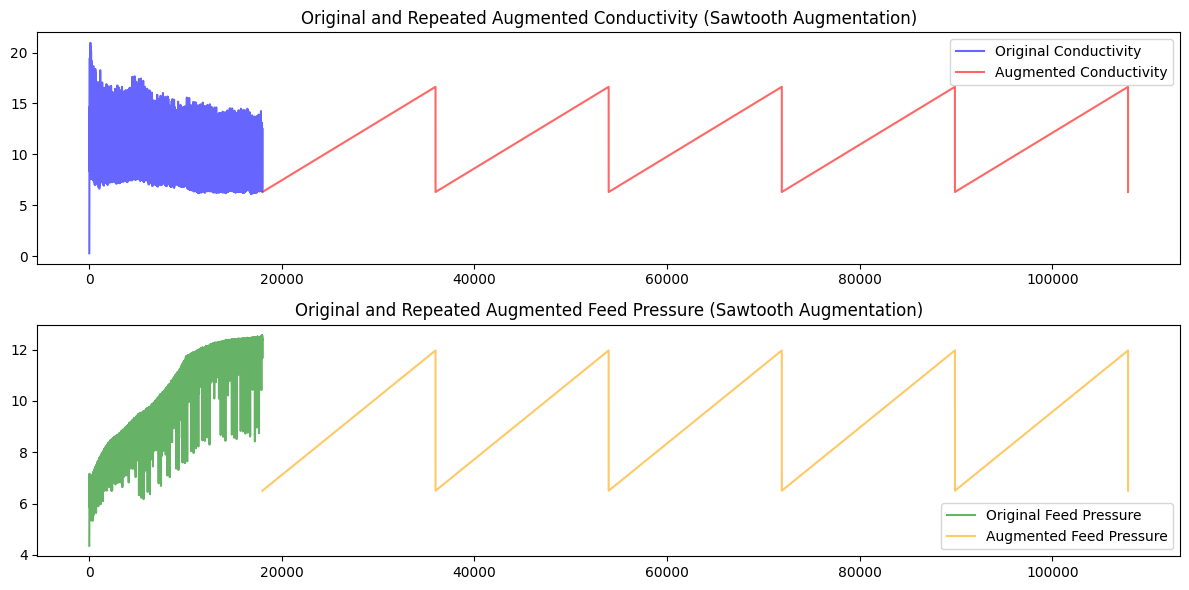

In [105]:
# ---------------- 톱니함수 기반 증강 ---------------- #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal  # 톱니 함수 생성에 사용

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 반복되는 톱니 함수 기반 증강 함수
def apply_repeating_sawtooth_augmentation(data, amplitude=1, period=1, cycles=3, repetitions=5):
    print("amplitude: ", amplitude)
    """
    반복되는 톱니 함수 기반 데이터 증강
    amplitude: 톱니 함수의 진폭 (최고점)
    period: 톱니 함수의 주기 (얼마나 자주 최고점에서 하락할지 설정)
    cycles: 톱니 패턴의 반복 횟수 (한 번의 반복에서 톱니가 몇 번 나타날지)
    repetitions: 전체적으로 톱니 패턴을 몇 번 반복할지 설정
    """
    augmented_data = []
    start_value = data[9]  # 시작점을 기존 데이터의 10번째 값으로 설정
    print("start_value: ", start_value)

    for rep in range(repetitions):
        for cycle in range(cycles):
            # 톱니 함수 생성: 진폭은 일정하게 유지함
            x = np.linspace(0, 1, len(data))
            sawtooth_wave = amplitude * signal.sawtooth(2 * np.pi * period * x)

            # 톱니 파형의 시작점을 기존 데이터의 10번째 값에 맞춤
            sawtooth_wave += start_value - sawtooth_wave[0]

            # 데이터에 증강된 톱니 파형을 추가
            # print("sawtooth_wave: ", sawtooth_wave, " amplitude: ", amplitude)
            augmented_data.extend(sawtooth_wave)

    return np.array(augmented_data[:len(data) * repetitions])  # 원하는 반복 횟수만큼 자르기

# 톱니 함수 적용 (반복되는 톱니 패턴 적용, 진폭 1배로 유지)
augmented_conductivity = apply_repeating_sawtooth_augmentation(
    original_conductivity, amplitude=(np.max(original_conductivity) - np.min(original_conductivity)) / 4, period=1, cycles=3, repetitions=5)
augmented_feed_pressure = apply_repeating_sawtooth_augmentation(
    original_feed_pressure, amplitude=(np.max(original_feed_pressure) - np.min(original_feed_pressure)) / 3, period=1, cycles=3, repetitions=5)

# 기존 데이터에 증강된 데이터 추가
combined_conductivity = np.concatenate([original_conductivity, augmented_conductivity])
combined_feed_pressure = np.concatenate([original_feed_pressure, augmented_feed_pressure])

# 증강된 데이터와 원본 데이터를 구분하여 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(original_conductivity)), original_conductivity, label='Original Conductivity', color='blue', alpha=0.6)
plt.plot(np.arange(len(original_conductivity), len(combined_conductivity)), augmented_conductivity, label='Augmented Conductivity', color='red', alpha=0.6)
plt.title('Original and Repeated Augmented Conductivity (Sawtooth Augmentation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(original_feed_pressure)), original_feed_pressure, label='Original Feed Pressure', color='green', alpha=0.6)
plt.plot(np.arange(len(original_feed_pressure), len(combined_feed_pressure)), augmented_feed_pressure, label='Augmented Feed Pressure', color='orange', alpha=0.6)
plt.title('Original and Repeated Augmented Feed Pressure (Sawtooth Augmentation)')
plt.legend()

plt.tight_layout()
plt.show()


amplitude:  5.1584634185347955
start_value:  6.318340101240474
amplitude:  2.7338566084441163
start_value:  6.501892160816598


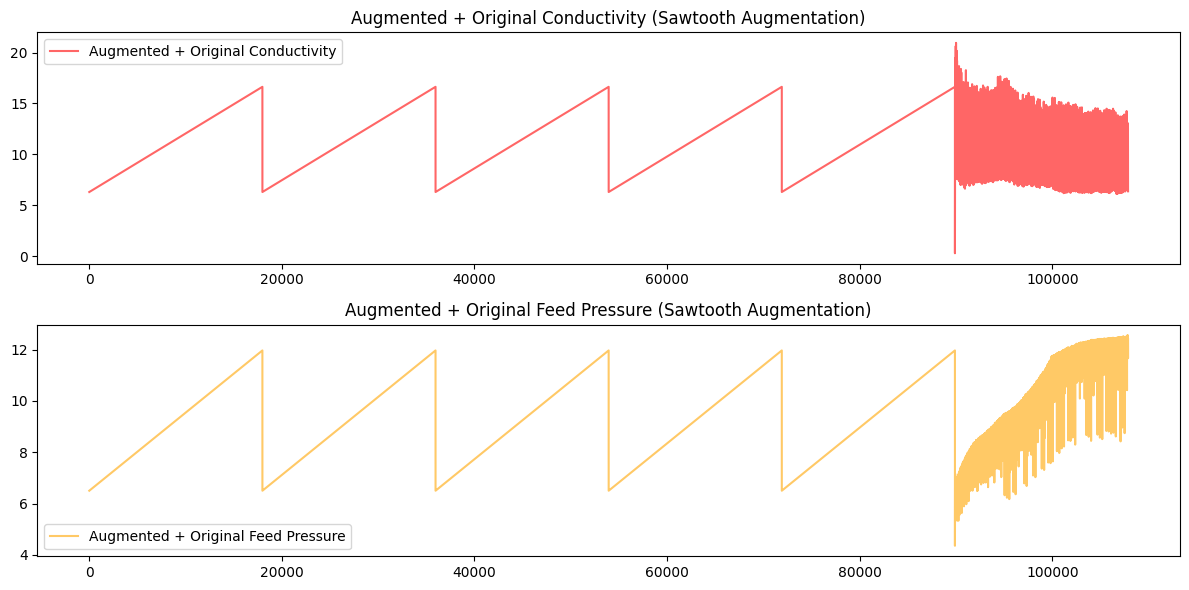

In [107]:
# ---------------- 톱니함수 기반 증강 ---------------- #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal  # 톱니 함수 생성에 사용

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 반복되는 톱니 함수 기반 증강 함수
def apply_repeating_sawtooth_augmentation(data, amplitude=1, period=1, cycles=3, repetitions=5):
    print("amplitude: ", amplitude)
    """
    반복되는 톱니 함수 기반 데이터 증강
    amplitude: 톱니 함수의 진폭 (최고점)
    period: 톱니 함수의 주기 (얼마나 자주 최고점에서 하락할지 설정)
    cycles: 톱니 패턴의 반복 횟수 (한 번의 반복에서 톱니가 몇 번 나타날지)
    repetitions: 전체적으로 톱니 패턴을 몇 번 반복할지 설정
    """
    augmented_data = []
    start_value = data[9]  # 시작점을 기존 데이터의 10번째 값으로 설정
    print("start_value: ", start_value)

    for rep in range(repetitions):
        for cycle in range(cycles):
            # 톱니 함수 생성: 진폭은 일정하게 유지함
            x = np.linspace(0, 1, len(data))
            sawtooth_wave = amplitude * signal.sawtooth(2 * np.pi * period * x)

            # 톱니 파형의 시작점을 기존 데이터의 10번째 값에 맞춤
            sawtooth_wave += start_value - sawtooth_wave[0]

            # 데이터에 증강된 톱니 파형을 추가
            augmented_data.extend(sawtooth_wave)

    return np.array(augmented_data[:len(data) * repetitions])  # 원하는 반복 횟수만큼 자르기

# 톱니 함수 적용 (반복되는 톱니 패턴 적용, 진폭 1배로 유지)
augmented_conductivity = apply_repeating_sawtooth_augmentation(
    original_conductivity, amplitude=(np.max(original_conductivity) - np.min(original_conductivity)) / 4, period=1, cycles=3, repetitions=5)
augmented_feed_pressure = apply_repeating_sawtooth_augmentation(
    original_feed_pressure, amplitude=(np.max(original_feed_pressure) - np.min(original_feed_pressure)) / 3, period=1, cycles=3, repetitions=5)

# 기존 데이터 앞에 증강된 데이터 추가
combined_conductivity = np.concatenate([augmented_conductivity, original_conductivity])
combined_feed_pressure = np.concatenate([augmented_feed_pressure, original_feed_pressure])

# 증강된 데이터와 원본 데이터를 구분하여 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(combined_conductivity)), combined_conductivity, label='Augmented + Original Conductivity', color='red', alpha=0.6)
plt.title('Augmented + Original Conductivity (Sawtooth Augmentation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(combined_feed_pressure)), combined_feed_pressure, label='Augmented + Original Feed Pressure', color='orange', alpha=0.6)
plt.title('Augmented + Original Feed Pressure (Sawtooth Augmentation)')
plt.legend()

plt.tight_layout()
plt.show()


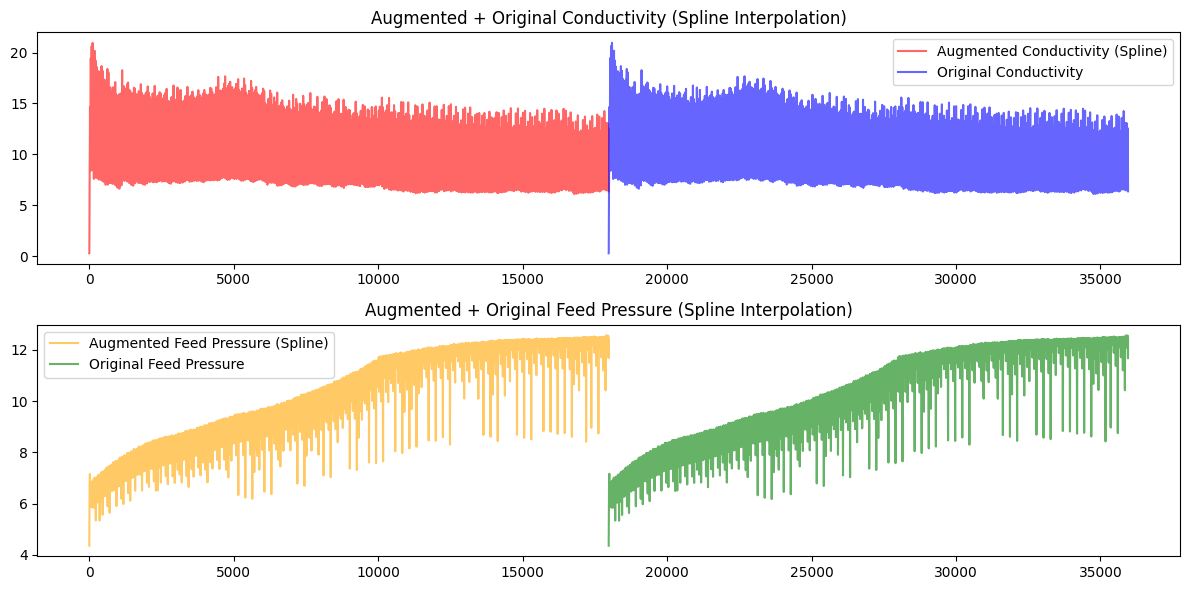

In [110]:
# ---------------- 스플라인 보간법을 이용한 증강 ---------------- #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 스플라인 보간법을 사용한 자연스러운 증강 함수
def apply_spline_augmentation(data):
    """
    스플라인 보간법을 사용하여 자연스럽게 증강
    원본 데이터와 동일한 개수로 증강
    """
    x = np.arange(len(data))
    spline = UnivariateSpline(x, data, s=0.5)  # s 파라미터는 부드러움을 조정
    x_new = np.linspace(x.min(), x.max(), len(data))  # 원본 데이터와 동일한 길이로 설정
    data_augmented = spline(x_new)
    return data_augmented

# 스플라인 보간법을 사용한 증강 데이터 생성 (원본 데이터와 동일한 개수)
augmented_conductivity_spline = apply_spline_augmentation(original_conductivity)
augmented_feed_pressure_spline = apply_spline_augmentation(original_feed_pressure)

# 기존 데이터에 증강된 데이터 추가
combined_conductivity_spline = np.concatenate([augmented_conductivity_spline, original_conductivity])
combined_feed_pressure_spline = np.concatenate([augmented_feed_pressure_spline, original_feed_pressure])

# 증강된 데이터와 원본 데이터를 구분하여 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(augmented_conductivity_spline)), augmented_conductivity_spline, label='Augmented Conductivity (Spline)', color='red', alpha=0.6)
plt.plot(np.arange(len(augmented_conductivity_spline), len(combined_conductivity_spline)), original_conductivity, label='Original Conductivity', color='blue', alpha=0.6)
plt.title('Augmented + Original Conductivity (Spline Interpolation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(augmented_feed_pressure_spline)), augmented_feed_pressure_spline, label='Augmented Feed Pressure (Spline)', color='orange', alpha=0.6)
plt.plot(np.arange(len(augmented_feed_pressure_spline), len(combined_feed_pressure_spline)), original_feed_pressure, label='Original Feed Pressure', color='green', alpha=0.6)
plt.title('Augmented + Original Feed Pressure (Spline Interpolation)')
plt.legend()

plt.tight_layout()
plt.show()


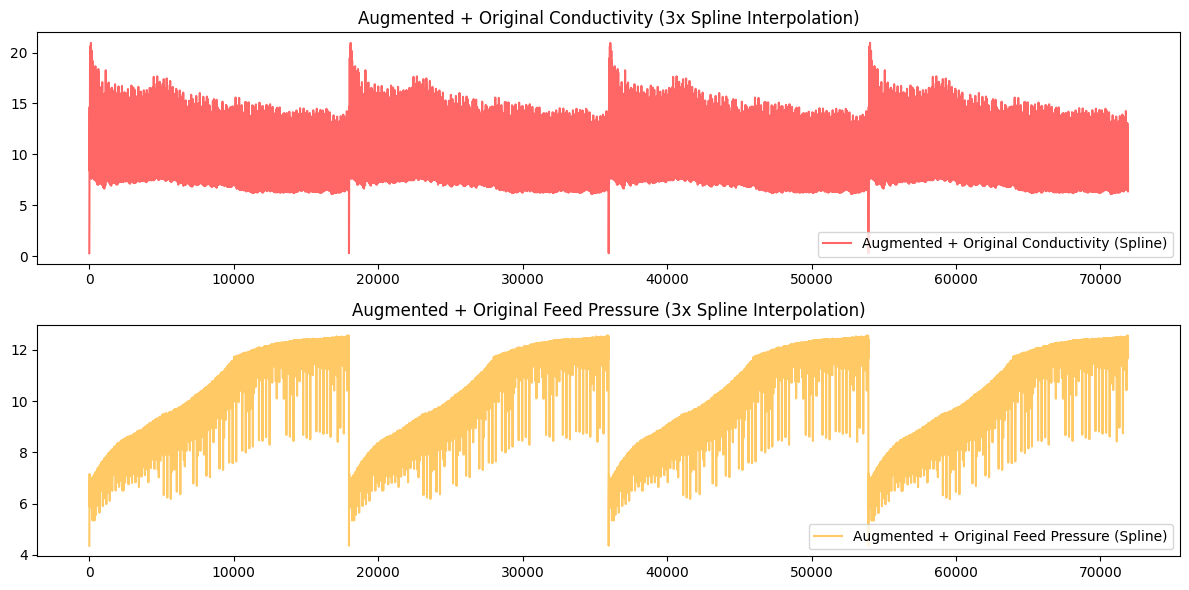

In [114]:
# ---------------- 스플라인 보간법을 이용한 증강, 증강 데이터 개수 늘림 ---------------- #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 스플라인 보간법을 사용한 자연스러운 증강 함수
def apply_spline_augmentation(data):
    """
    스플라인 보간법을 사용하여 자연스럽게 증강
    원본 데이터와 동일한 길이로 증강
    """
    x = np.arange(len(data))
    spline = UnivariateSpline(x, data, s=0.5)  # s 파라미터는 부드러움을 조정
    x_new = np.linspace(x.min(), x.max(), len(data))  # 원본 데이터와 동일한 길이로 설정
    data_augmented = spline(x_new)
    return data_augmented

# 스플라인 보간법을 사용한 증강 데이터 생성 (원본 데이터와 동일한 길이)
augmented_conductivity_spline = apply_spline_augmentation(original_conductivity)
augmented_feed_pressure_spline = apply_spline_augmentation(original_feed_pressure)

# 증강된 데이터를 3번 반복해서 결합
combined_conductivity_spline = np.concatenate([augmented_conductivity_spline, augmented_conductivity_spline, augmented_conductivity_spline, original_conductivity])
combined_feed_pressure_spline = np.concatenate([augmented_feed_pressure_spline, augmented_feed_pressure_spline, augmented_feed_pressure_spline, original_feed_pressure])

# 증강된 데이터와 원본 데이터를 구분하여 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(combined_conductivity_spline)), combined_conductivity_spline, label='Augmented + Original Conductivity (Spline)', color='red', alpha=0.6)
plt.title('Augmented + Original Conductivity (3x Spline Interpolation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(combined_feed_pressure_spline)), combined_feed_pressure_spline, label='Augmented + Original Feed Pressure (Spline)', color='orange', alpha=0.6)
plt.title('Augmented + Original Feed Pressure (3x Spline Interpolation)')
plt.legend()

plt.tight_layout()
plt.show()


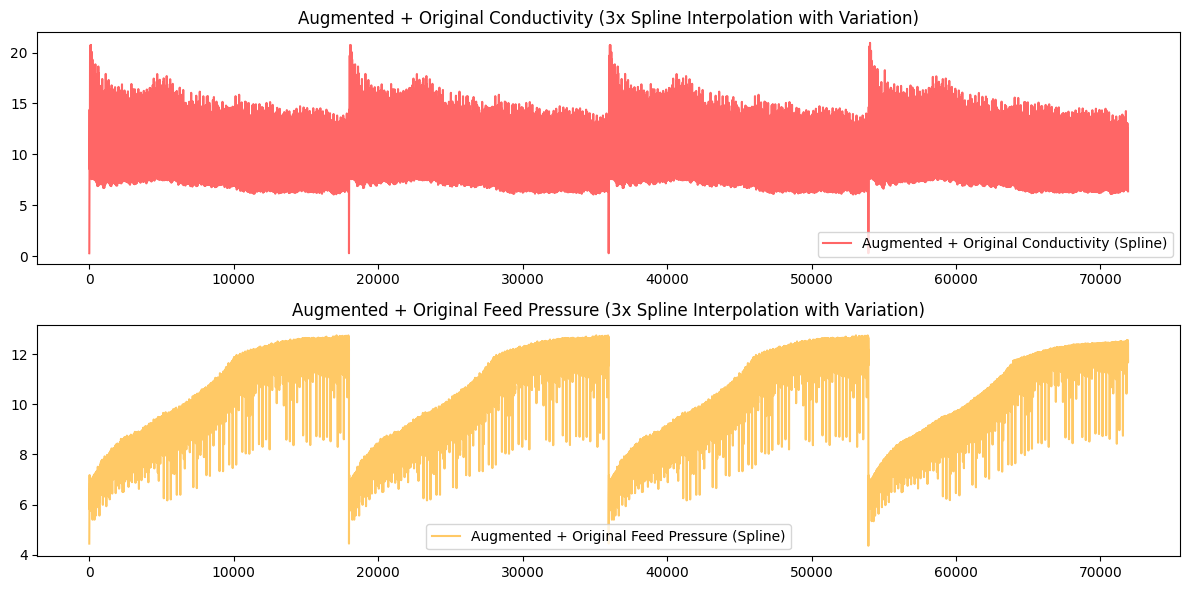

In [117]:
# ---------------- 스플라인 보간법 및 값 변형을 통한 증강, 증강 데이터 개수 늘림 ---------------- #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 스플라인 보간법을 사용한 자연스러운 증강 함수
def apply_spline_augmentation(data):
    """
    스플라인 보간법을 사용하여 자연스럽게 증강
    원본 데이터와 동일한 길이로 증강
    """
    x = np.arange(len(data))
    spline = UnivariateSpline(x, data, s=0.5)  # s 파라미터는 부드러움을 조정
    x_new = np.linspace(x.min(), x.max(), len(data))  # 원본 데이터와 동일한 길이로 설정
    data_augmented = spline(x_new)
    return data_augmented

# 약간의 변형을 주는 함수 (각 데이터에 약간의 비율 변형)
def apply_value_variation(data, variation_strength=0.02):
    """
    데이터에 작은 비율의 변형을 주는 함수
    variation_strength: 변형의 강도 (기본 2% 변형)
    """
    variation = 1 + np.random.uniform(-variation_strength, variation_strength, size=data.shape)
    return data * variation

# 스플라인 보간법을 사용한 증강 데이터 생성 (원본 데이터와 동일한 길이)
augmented_conductivity_spline = apply_spline_augmentation(original_conductivity)
augmented_feed_pressure_spline = apply_spline_augmentation(original_feed_pressure)

# 변형을 적용한 증강 데이터 생성
augmented_conductivity_spline_varied = apply_value_variation(augmented_conductivity_spline)
augmented_feed_pressure_spline_varied = apply_value_variation(augmented_feed_pressure_spline)

# 증강된 데이터를 3번 반복해서 결합
combined_conductivity_spline = np.concatenate([augmented_conductivity_spline_varied, augmented_conductivity_spline_varied, augmented_conductivity_spline_varied, original_conductivity])
combined_feed_pressure_spline = np.concatenate([augmented_feed_pressure_spline_varied, augmented_feed_pressure_spline_varied, augmented_feed_pressure_spline_varied, original_feed_pressure])

# 증강된 데이터와 원본 데이터를 구분하여 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(combined_conductivity_spline)), combined_conductivity_spline, label='Augmented + Original Conductivity (Spline)', color='red', alpha=0.6)
plt.title('Augmented + Original Conductivity (3x Spline Interpolation with Variation)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(combined_feed_pressure_spline)), combined_feed_pressure_spline, label='Augmented + Original Feed Pressure (Spline)', color='orange', alpha=0.6)
plt.title('Augmented + Original Feed Pressure (3x Spline Interpolation with Variation)')
plt.legend()

plt.tight_layout()
plt.show()


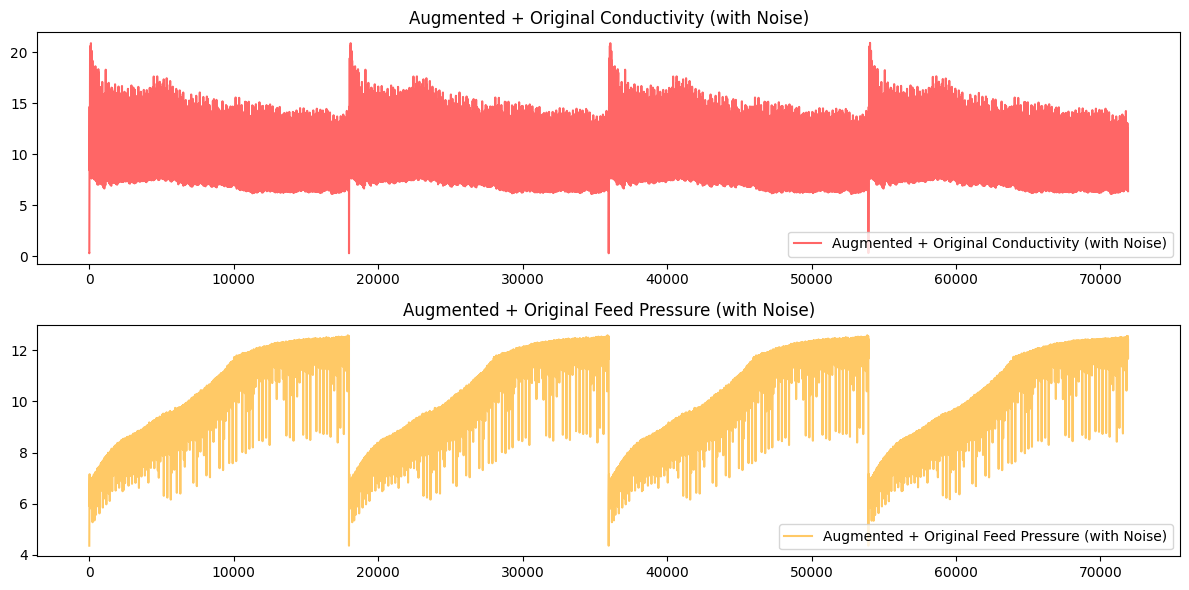

In [118]:
# ---------------- 노이즈 증가를 통한 증강, 증강 데이터 개수 늘림 ---------------- #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 기존 데이터에서 처리된 데이터를 준비
original_conductivity = final_processed_df['Processed Conductivity'].values
original_feed_pressure = final_processed_df['Processed Feed Pressure'].values

# 노이즈 추가법을 사용한 증강 함수
def add_noise(data, noise_level=0.02):
    """
    데이터에 노이즈를 추가하여 증강하는 함수
    noise_level: 추가되는 노이즈의 강도 (기본 2%)
    """
    noise = np.random.normal(0, noise_level, len(data))  # 평균 0, 표준편차 noise_level의 노이즈 생성
    return data + noise

# 노이즈를 추가한 증강 데이터 생성
augmented_conductivity = add_noise(original_conductivity, noise_level=0.02)
augmented_feed_pressure = add_noise(original_feed_pressure, noise_level=0.02)

# 증강된 데이터를 3번 반복해서 결합
combined_conductivity = np.concatenate([augmented_conductivity, augmented_conductivity, augmented_conductivity, original_conductivity])
combined_feed_pressure = np.concatenate([augmented_feed_pressure, augmented_feed_pressure, augmented_feed_pressure, original_feed_pressure])

# 증강된 데이터와 원본 데이터를 구분하여 시각화
plt.figure(figsize=(12, 6))

# 원본 및 증강된 전도도 데이터 비교
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(combined_conductivity)), combined_conductivity, label='Augmented + Original Conductivity (with Noise)', color='red', alpha=0.6)
plt.title('Augmented + Original Conductivity (with Noise)')
plt.legend()

# 원본 및 증강된 압력 데이터 비교
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(combined_feed_pressure)), combined_feed_pressure, label='Augmented + Original Feed Pressure (with Noise)', color='orange', alpha=0.6)
plt.title('Augmented + Original Feed Pressure (with Noise)')
plt.legend()

plt.tight_layout()
plt.show()
